<a href="https://colab.research.google.com/github/pranshumalik14/ece421-labs-hw/blob/main/labs/lab1/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Logistic Regression

In this lab, we will be creating a binary classifier using Logistic Regression first implemented using Numpy and then using Tensorflow. The classifier has to be trained on the `notMNIST` dataset, and particularly classify only between the letters `C` (positive class, labelled `1`) and `J` (negative class, labelled `0`). This dataset, representing the ground truth, will be represented as $\mathcal{D}= \{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where there are $N$ datavectors $\mathbf{x}_i \in \mathbb{R}^d$ and labels $y_i \in \{0, 1\}$.

## 1. Logistic Regression with Numpy

We use the following model for computing the probability of a datavector $\mathbf{x}_n\in\mathbb{R}^d$ belonging to a particular class $y_n\in \{0, 1\}$:

$$\hat{p}_\mathbf{w}(y_n\mid \mathbf{x}_n) = \sigma\left((2y_n-1)(\mathbf{w}^\top\mathbf{x}_n + b)\right),$$

given the model parameters $\mathbf{w} \in \mathbb{R}^d$ (wieght) and $b \in \mathbb{R}$ (bias), and the logistic (or sigmoid) function $\sigma(z) = \frac{1}{1+e^{-z}}$.

However, to simply expressions we will augment our datavectors $\mathbf{x}_i$ with ones and accordingly increment the dimension of the weightvector, such that $\mathbf{x}_i = \begin{bmatrix}1 & x_1 & \ldots & x_d\end{bmatrix} \in \mathbb{R}^{d+1}$ and $\mathbf{w} = \begin{bmatrix}b & w_1 & \ldots & w_d \end{bmatrix}\in \mathbb{R}^{d+1}$. This will yield the (binary) label prediction probability to be:

$$\hat{p}_\mathbf{w}(y_n\mid \mathbf{x}_n) = \sigma\left((2y_n-1)(\mathbf{w}^\top\mathbf{x}_n)\right).$$
No changes are made to the label sequence $y_i$. Also note that the corresponding changes to function signatures were made, so the functions defined in this document (e.g. `loss` and `grad_loss`) will differ slightly from the lab handout.

### 1.1 Loss Function and Gradient 

We will use the regularized loss function (in-sample error) for minimization while training over the dataset:

$$\begin{align*}
E_{\text{in}, \lambda}(\mathbf{w}) &= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N -\log\left(\hat{p}_\mathbf{w}(y_n\mid \mathbf{x}_n)\right)\\
&= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N \big[-I(y_n=1)\log(\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n)) -I(y_n=0)\log(\hat{p}_\mathbf{w}(0\mid \mathbf{x}_n))\big] \quad \triangleright \text{since } y_n \text{ only has two possibilities}\\
&= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N \big[-y_n\log(\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n)) -(1-y_n)\log(1-\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n))\big]\\
&= \lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N \big[y_n\log(1 + e^{-\mathbf{w}^\top\mathbf{x}_n})) +(1-y_n)\log(1+e^{\mathbf{w}^\top\mathbf{x}_n})\big],
\end{align*}
$$
where $\lambda > 0$ is the regularization constant and $I(p)$ is the identifier function defined to be, $I(p) = \begin{cases}1 & \text{predicate } p \text{ is true}\\ 0 & \text{predicate } p \text{ is false}\end{cases}$

The gradient of the loss function is:

$$
\begin{align*}
∇_{\mathbf{w}}E_{\text{in}, \lambda}(\mathbf{w}) &= ∇_{\mathbf{w}}\lambda||\mathbf{w}||^2 + \frac{1}{N}\sum_{n=1}^N ∇_{\mathbf{w}}\big[-y_n\log(\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n)) -(1-y_n)\log(1-\hat{p}_\mathbf{w}(1\mid \mathbf{x}_n))\big]\\
&=2\lambda\mathbf{w} + \frac{1}{N}\sum_{n=1}^N\big[-y_n(1+e^{-\mathbf{w}^\top\mathbf{x}_n})∇_{\mathbf{w}}(1+e^{-\mathbf{w}^\top\mathbf{x}_n})^{-1}-(1-y_n)(1+e^{\mathbf{w}^\top\mathbf{x}_n})∇_{\mathbf{w}}(1+e^{\mathbf{w}^\top\mathbf{x}_n})^{-1}\big]\\
&=2\lambda\mathbf{w} + \frac{1}{N}\sum_{n=1}^N\big[-y_n\mathbf{x}_n\underbrace{\frac{e^{-\mathbf{w}^\top\mathbf{x}_n}}{(1+e^{-\mathbf{w}^\top\mathbf{x}_n})}}_{\sigma(-\mathbf{w}^\top\mathbf{x}_n) = 1-\sigma(\mathbf{w}^\top\mathbf{x}_n)}+(1-y_n)\mathbf{x}_n\underbrace{\frac{e^{\mathbf{w}^\top\mathbf{x}_n}}{(1+e^{\mathbf{w}^\top\mathbf{x}_n})}}_{\sigma(\mathbf{w}^\top\mathbf{x}_n)}\big]\\
&=2\lambda\mathbf{w} + \frac{1}{N}\sum_{n=1}^N \mathbf{x}_n\left(\sigma(\mathbf{w}^\top\mathbf{x}_n)-y_n\right)\\
&=2\lambda\mathbf{w} + \frac{1}{N}\mathbf{X}^\top\left(\boldsymbol{\sigma}(\mathbf{X}\mathbf{w})-\mathbf{y}\right), 
\end{align*}
$$

where $\mathbf{X} = \begin{bmatrix}\mathbf{x}_1^\top\\\vdots\\\mathbf{x}_N^\top\end{bmatrix}\in \mathbb{R}^{N\times(d+1)}$ is the datamatrix, $\mathbf{y} \in \{0,1\}^{N}$ is the labelvector, and $\boldsymbol{\sigma}(\cdot)$ is a vector function acting element-wise on the input vector by applying the (scalar) logistic function.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sigmoid = lambda z: 1 / (1 + np.exp(-z))

In [4]:
def loss(w, X, ys, reg_lambda):
    Xw = X @ w # logits
    logit_CE_loss = ys*np.log(1 + np.exp(-Xw)) + (1 - ys)*np.log(1 + np.exp(Xw))
    # return regularization penalty + cross entropy loss
    return reg_lambda*np.linalg.norm(w)**2 + logit_CE_loss.mean()

In [5]:
def grad_loss(w, X, ys, reg_lambda):
    return 2*reg_lambda*w + 1/X.shape[0]*(X.T @ (sigmoid(X@w) - ys))

Here we also define the `accuracy` function that will evaluate the mean of the number of misclassifications, giving us a probability of $\hat{p}_{\mathbf{w}}(y_n\mid\mathbf{x}_n)$ favoring the opposite label. This will help us objectively evaluate how the loss corresponds to the performance of the linear (logistic regression) model.

In [6]:
def accuracy(w, X, ys):
    p_hat  = sigmoid(X@w)    # predicted probability for yn=1
    ys_hat = np.round(p_hat) # corresponding predicted labels
    return (ys_hat == ys).mean()

### 1.2 Gradient Descent Implementation

The update step is:

$$\mathbf{w}_{k+1} = \mathbf{w}_k - ϵ\underbrace{∇_{\mathbf{w}}E_{\text{in}, λ}(\mathbf{w}_k)}_{\texttt{grad_loss}(\mathbf{w}_k)},$$

This is batch GD, with batch size N

where $ϵ > 0$ is the learning rate.

In [7]:
def grad_descent(w, Xs, Ys, eps, epochs, reg_lambda, error_tol=1e-7):
    # Xs = [X_train, X_valid (optional), X_test (optional)]
    # Ys = [ys_train, ys_valid (optional), ys_test (optional)]
    w_opt     = np.copy(w)
    loss_hist = np.empty((0,Xs.shape[0]), float)
    acc_hist  = np.empty((0,Xs.shape[0]), float)
    for epoch in range(epochs):
        grad_w = grad_loss(w, Xs[0], Ys[0], reg_lambda)
        w_opt  = w - eps*grad_w
        if np.linalg.norm(w-w_opt)**2 < error_tol:
            break
        else:
            w = w_opt
        loss_hist = np.append(loss_hist, [[loss(w, Xs[i], Ys[i], reg_lambda) for i in range(Xs.shape[0])]], axis=0)
        acc_hist  = np.append(acc_hist, [[accuracy(w, Xs[i], Ys[i]) for i in range(Xs.shape[0])]], axis=0)
    return w_opt, loss_hist, acc_hist

Now we will test it on the data. The `notMNIST` dataset has images of size $28\times 28$, thus we have $d=784$. 

In [8]:
# load data
def loadDataGDrive():
    with np.load('/content/drive/MyDrive/Colab Notebooks/notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

x_train, x_valid, x_test, ys_train, ys_valid, ys_test = loadDataGDrive()

In [9]:
# augment and reshape datavectors
X_train = np.concatenate([np.ones((x_train.shape[0])).reshape(-1, 1), x_train.reshape(x_train.shape[0], -1)], axis=1)
X_valid = np.concatenate([np.ones((x_valid.shape[0])).reshape(-1, 1), x_valid.reshape(x_valid.shape[0], -1)], axis=1)
X_test  = np.concatenate([np.ones((x_test.shape[0])).reshape(-1, 1), x_test.reshape(x_test.shape[0], -1)], axis=1)

# cast labels to float for error-free numerical calculations
ys_train, ys_valid, ys_test = ys_train.astype(float), ys_valid.astype(float), ys_test.astype(float)

# data for gradient descent
Xs     = np.array([X_train, X_valid, X_test], dtype=object)    # training, validation, and testing data
Ys     = np.array([ys_train, ys_valid, ys_test], dtype=object) # training, validation, and testing labels

In [10]:
def plot_learning_history(title, loss_hist, acc_hist):
    # loss_hist = [train_loss, valid_loss, test_loss]
    # acc_hist  = [train_acc, valid_acc, test_acc]
    f, ax  = plt.subplots(1, 2, figsize=(8,4))
    labels = ["Train", "Validation", "Test"]

    for i in range(loss_hist.shape[1]):
        ax[0].plot(loss_hist[:, i], label=labels[i]) # plot loss history on left
        ax[1].plot(acc_hist[:, i], label=labels[i])  # plot accuracy history on right
    
    # add lables and title
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    f.suptitle(title, fontsize=14, y=1.03)
    return plt.tight_layout()

### 1.3 Tuning the Learning Rate

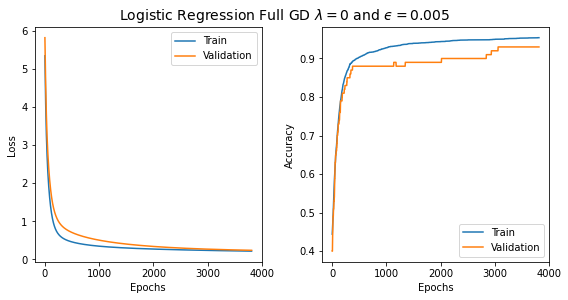

In [38]:
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1)) # initial weight vector
_, loss_history, accuracy_history = grad_descent(w_init, Xs, Ys, 0.005, 5000, 0)
title  = r"Logistic Regression Full GD $\lambda={}$ and $ϵ={}$".format(0, 0.005)
plot_learning_history(title, loss_history[:, 0:2], accuracy_history[:, 0:2])

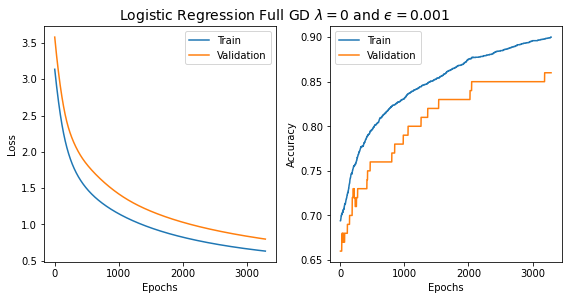

In [25]:
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1)) # initial weight vector
_, loss_history_eps_0p001, accuracy_history_eps_0p001 = grad_descent(w_init, Xs, Ys, 0.001, 5000, 0)
title  = r"Logistic Regression Full GD $\lambda={}$ and $ϵ={}$".format(0, 0.001)
plot_learning_history(title, loss_history_eps_0p001[:, 0:2], accuracy_history_eps_0p001[:, 0:2])

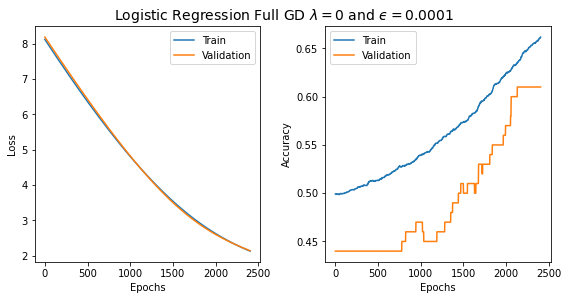

In [16]:
w_init = np.random.normal(0.001, 0.99, (X_train.shape[1], 1)) # initial weight vector
_, loss_history_eps_0p0001, accuracy_history_eps_0p0001 = grad_descent(w_init, Xs, Ys, 0.0001, 5000, 0)
title  = r"Logistic Regression Full GD $\lambda={}$ and $ϵ={}$".format(0, 0.0001)
plot_learning_history(title, loss_history_eps_0p0001[:, 0:2], accuracy_history_eps_0p0001[:, 0:2])

### 1.4 Generalization


## 2. Logistic Regression in TensorFlow


### 2.1 Logistic Regression Model Setup

In [18]:
%tensorflow_version 2.x
import tensorflow as tf2
import dataclasses as data

In [19]:
def loss_tf2(w, X, ys, reg_lambda):
    Xw = tf2.linalg.matmul(X, w) # logits
    reg_loss = 2*reg_lambda*tf2.nn.l2_loss(w)
    logits_CE_loss = tf2.nn.sigmoid_cross_entropy_with_logits(labels=ys, logits=Xw)
    return reg_loss + tf2.reduce_mean(logits_CE_loss)

In [20]:
def accuracy_tf2(w, X, ys):
    p_hat  = tf2.math.sigmoid(tf2.linalg.matmul(X, w)) # predicted probability for yn=1
    ys_hat = tf2.round(p_hat)                          # corresponding predicted labels
    return tf2.reduce_mean(tf2.cast(tf2.equal(ys_hat, ys), dtype=tf2.float64))

In [21]:
@data.dataclass # for ADAM optimizer and Batch SGD
class Options:  # initial values same as default for keras.optimizers.Adam
    alpha: float = 0.001
    beta1: float = 0.9
    beta2: float = 0.999
    epsilon: float = 1e-07
    batchsz: int   = 500

In [22]:
def logistic_reg_tf2(Xs, Ys, reg_lambda, options, epochs=700):
    # Xs = [X_train, X_valid (optional), X_test (optional)]
    # Ys = [ys_train, ys_valid (optional), ys_test (optional)]

    # initialize the (augmented) weight vector
    w = tf2.Variable(initial_value=tf2.random.truncated_normal([Xs[0].shape[1]-1,1], stddev=0.5, dtype=tf2.float64))
    b = tf2.Variable(0.0, dtype=tf2.float64)
    w = tf2.Variable(tf2.concat([[[b]], w], axis=0))

    # initialize ADAM optimizer
    alpha, beta1, beta2, epsilon, _ = data.astuple(options)
    optimizer = tf2.keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2, epsilon=epsilon)

    # train model
    return train_logistic_reg_tf2_model(w, Xs, Ys, reg_lambda, optimizer, options, epochs)

### 2.2 Implementing Stochastic Gradient Descent

The idea in classical stochastic gradient descent procedure is:

In expectation, it will follow.

Although `Adam` has its own momentum-based update rules that will work on top of the gra

In [24]:
def shuffle_data(X, ys):
    # https://valueml.com/shuffle-the-training-data-in-tensorflow/
    indices = tf2.range(start=0, limit=X.shape[0], dtype=tf2.int32)
    shuffled_indices = tf2.random.shuffle(indices)

    shuffled_x = tf2.gather(X, shuffled_indices)
    shuffled_y = tf2.gather(ys, shuffled_indices)

    return shuffled_x, shuffled_y

In [25]:
def train_logistic_reg_tf2_model(w, Xs, Ys, reg_lambda, optimizer, options, epochs):
    # Xs = [X_train, X_valid (optional), X_test (optional)]
    # Ys = [ys_train, ys_valid (optional), ys_test (optional)]
    loss_hist   = np.empty((0,Xs.shape[0]), float)
    acc_hist    = np.empty((0,Xs.shape[0]), float)
    batch_size  = options.batchsz
    num_batches = int(Xs[0].shape[0]/batch_size)
    
    # mini-batch stochastic gradient descent
    for _ in range(epochs):
        X_shfld, ys_shfld = shuffle_data(Xs[0], Ys[0])
        
        for i in range(num_batches):
            batch_start, batch_end = i*batch_size, (i+1)*batch_size
            mini_X, mini_ys = X_shfld[batch_start:batch_end], ys_shfld[batch_start:batch_end]
            
            with tf2.GradientTape() as tape:
                tape.watch(w)
                train_loss = loss_tf2(w, mini_X, mini_ys, reg_lambda)
            
            grad = tape.gradient(train_loss, w)
            optimizer.apply_gradients([(grad, w)])

        loss_hist = np.append(loss_hist, [[loss_tf2(w, Xs[i], Ys[i], reg_lambda).numpy() for i in range(Xs.shape[0])]], axis=0)
        acc_hist  = np.append(acc_hist, [[accuracy_tf2(w, Xs[i], Ys[i]).numpy() for i in range(Xs.shape[0])]], axis=0)    
    return w, loss_hist, acc_hist

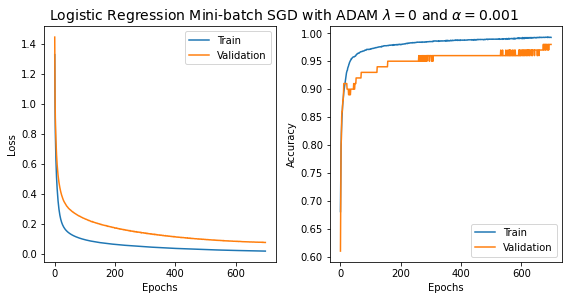

In [32]:
_, loss_history_tf2, accuracy_history_tf2 = logistic_reg_tf2(Xs, Ys, 0.0, Options())
title  = r"Logistic Regression Mini-batch SGD with ADAM $\lambda={}$ and $\alpha={}$".format(0, 0.001)
plot_learning_history(title, loss_history_tf2[:, 0:2], accuracy_history_tf2[:, 0:2])

### 2.3 Batch Size Investigation

The full gradient descent above in section 1.2. Now, we define a generic version, btach size B. This is the formulation. now do it in tensorflow.

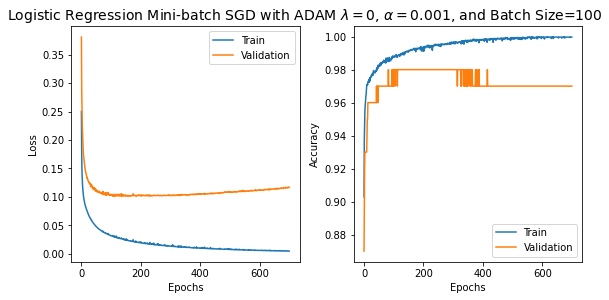

In [27]:
_, loss_history_bsz100, accuracy_history_bsz100 = logistic_reg_tf2(Xs, Ys, 0.0, Options(batchsz=100))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\lambda={}$, $\alpha={}$, and Batch Size={}".format(0, 0.001, 100)
plot_learning_history(title, loss_history_bsz100[:, 0:2], accuracy_history_bsz100[:, 0:2])

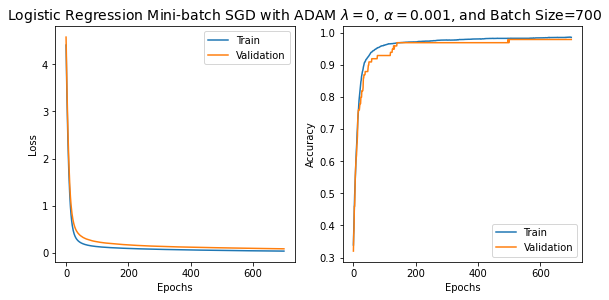

In [28]:
_, loss_history_bsz700, accuracy_history_bsz700 = logistic_reg_tf2(Xs, Ys, 0.0, Options(batchsz=700))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\lambda={}$, $\alpha={}$, and Batch Size={}".format(0, 0.001, 700)
plot_learning_history(title, loss_history_bsz700[:, 0:2], accuracy_history_bsz700[:, 0:2])

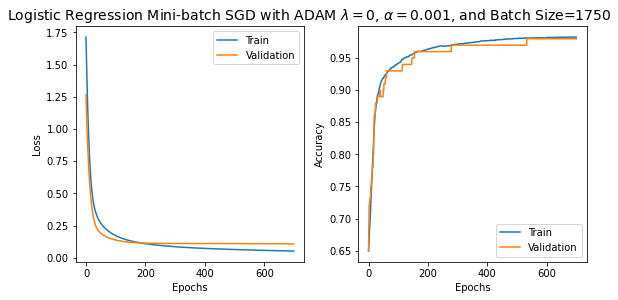

In [29]:
_, loss_history_bsz1750, accuracy_history_bsz1750 = logistic_reg_tf2(Xs, Ys, 0.0, Options(batchsz=1750))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\lambda={}$, $\alpha={}$, and Batch Size={}".format(0, 0.001, 1750)
plot_learning_history(title, loss_history_bsz1750[:, 0:2], accuracy_history_bsz1750[:, 0:2])

### 2.4 Hyperparameter Investigation

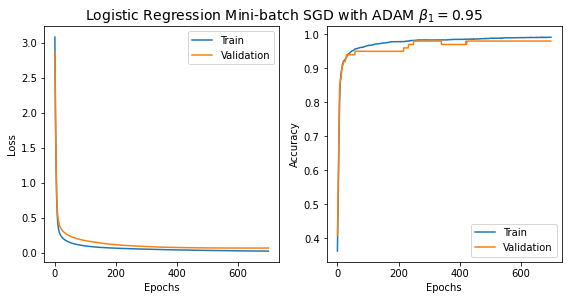

In [31]:
_, loss_history_beta1_0p95, accuracy_history_beta1_0p95 = logistic_reg_tf2(Xs, Ys, 0.0, Options(beta1=0.95))
title  = r"Logistic Regression Mini-batch SGD with ADAM $\beta_1={}$".format(0.95)
plot_learning_history(title, loss_history_beta1_0p95[:, 0:2], accuracy_history_beta1_0p95[:, 0:2])

### 2.5 Comparison against Full Gradient Descent

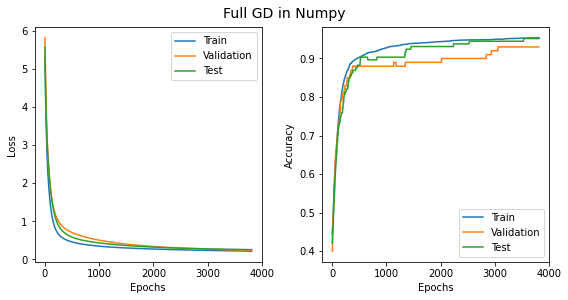

In [39]:
plot_learning_history("Full GD in Numpy", loss_history, accuracy_history)

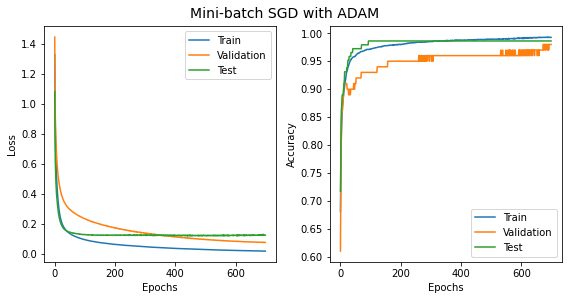

In [33]:
plot_learning_history("Mini-batch SGD with ADAM", loss_history_tf2, accuracy_history_tf2)